In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for multiple tockets
#50 tockets
# Scarica lista S&P500 da Wikipedia
tickers = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["Symbol"].tolist()

# Alcuni ticker hanno un punto (es. BRK.B, BF.B) → Yahoo li vuole con trattino
tickers = [t.replace(".", "-") for t in tickers]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
data = data.dropna(axis=1, how='all')

/tmp/ipykernel_1507/1040873868.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  503 of 503 completed


In [6]:
import sys
sys.path.append("../src")
from finrmt.data import returns

nan_frac = data.isna().mean()
# tieni solo colonne con meno del 5% di NaN
ok_cols = nan_frac[nan_frac <= 0.05].index
data_clean = data[ok_cols]
data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')
subset = data_clean.iloc[:, :100]

returns = returns(subset)

R = returns.dropna(how="any").to_numpy(dtype=float)   # shape: (T, N)

T, N = R.shape
print("R shape:", R.shape)
print("First 5 rows of R:\n", R[:5])

R shape: (501, 100)
First 5 rows of R:
 [[ 0.66090707  0.66010165  0.55296072  1.79207239  1.23228671  0.26746413
  -0.27178852  0.57976127  1.12160889 -1.90707708  0.36184662  0.76123025
   0.41426409  0.54205164 -1.25164247  0.30527135  0.96589712  0.85609852
   1.07186683  0.58802849  1.29173242  1.88608781  1.05228132  0.93746476
   1.03994695  0.68292818  0.29090573  0.14359926  0.70124407  0.40591026
   1.24127023 -0.51042842 -2.32511039  0.85314405  1.76866189 -1.42637363
   0.00507782  0.92815901  1.10742151  1.39509895  1.01946559  0.5688502
   1.28262766  0.33673494  1.51666812  1.53569008  0.02296973  1.36850236
   0.40434121  2.12163003  1.15108218  0.55406991  1.36463588  1.00720809
   0.63627151  1.44591184  0.58368951 -0.33978561 -0.36906967  1.73751471
   2.22054471 -1.82420094  0.68261301  1.02136824  0.34596519  1.21688511
   1.58825673  1.27386849  0.7993948   1.12737031  0.03753903  1.49911643
  -0.32295684  0.19174978  0.48826618  0.54871468  1.33032542 -1.2870277


/tmp/ipykernel_1507/3672626600.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')


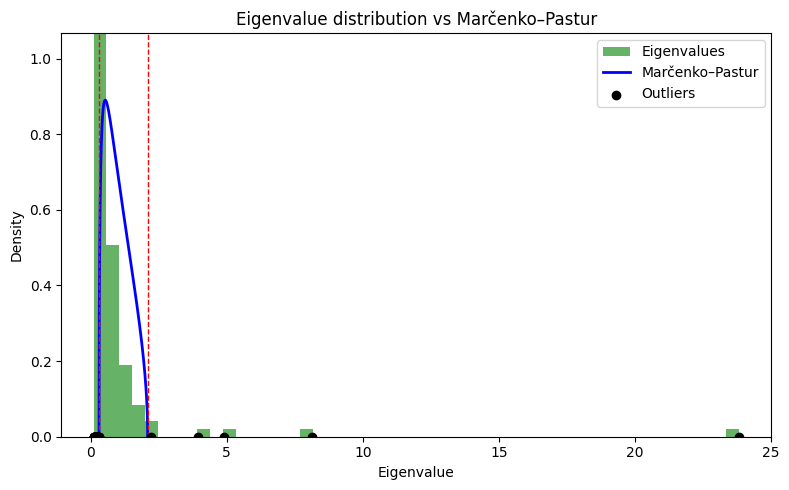

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
from finrmt.data import returns
from finrmt.rmt import mp_bounds
C = (1/T) * R.T @ R
eigvals = np.linalg.eigvalsh(C)

# bounds MP
lam_minus, lam_plus = mp_bounds(N, T, sigma2=1.0)
bounds = (lam_minus, lam_plus)
# istogramma autovalori
plt.figure(figsize=(8,5))
plt.hist(eigvals, bins=50, density=True, alpha=0.6, color='g', label="Eigenvalues")
q = N / T
# curva MP (analitica)
x = np.linspace(lam_minus, lam_plus, 400)
rho = (1/(2*np.pi*q*x)) * np.sqrt((lam_plus - x)*(x - lam_minus))
plt.plot(x, rho, 'b-', lw=2, label="Marčenko–Pastur")

# bounds verticali
plt.axvline(lam_minus, color='r', linestyle='dashed', lw=1)
plt.axvline(lam_plus, color='r', linestyle='dashed', lw=1)

# evidenzio outlier
outliers = eigvals[(eigvals < lam_minus) | (eigvals > lam_plus)]
plt.scatter(outliers, np.zeros_like(outliers), color='k', marker='o', zorder=5, label="Outliers")

# rescaling verticale (focalizza sul bulk)
plt.ylim(0, max(rho)*1.2)

plt.title("Eigenvalue distribution vs Marčenko–Pastur")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


confronto con matrice gaussiana

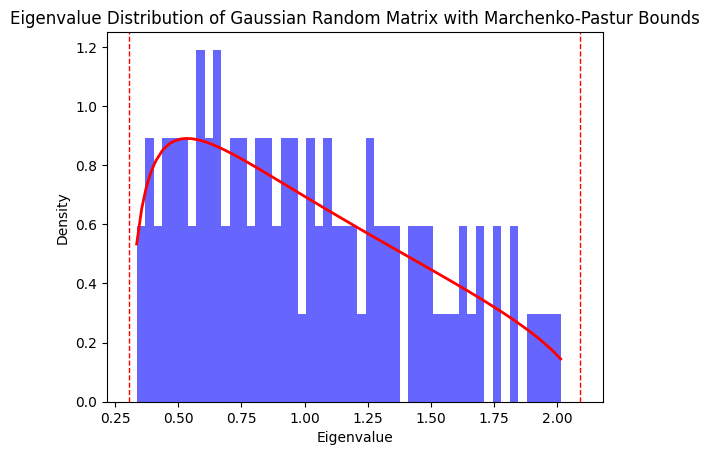

/tmp/ipykernel_1507/1469395808.py:28: RuntimeWarning: invalid value encountered in sqrt
  mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[0] - x)*(x - bounds[1])) / x


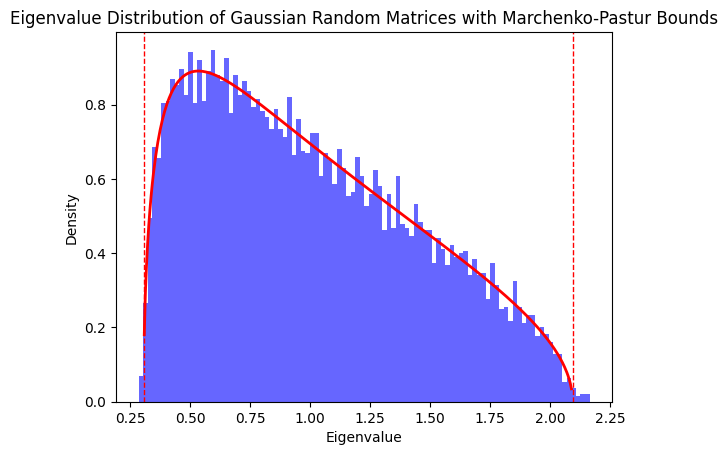

In [8]:

R_gauss = np.random.normal(0, 1, size=(T, N))
C_gauss = (1/T) * R_gauss.T @ R_gauss
eigvals_gauss = np.linalg.eigvalsh(C_gauss)
plt.hist(eigvals_gauss, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-eigvals_gauss)*(eigvals_gauss-bounds[0])) / eigvals_gauss
plt.plot(eigvals_gauss, mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrix with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()

#generate many gaussians
num_simulations = 100
all_eigvals = []
for _ in range(num_simulations):
    R_gauss = np.random.normal(0, 1, size=(T, N))
    C_gauss = (1/T) * R_gauss.T @ R_gauss
    eigvals_gauss = np.linalg.eigvalsh(C_gauss)
    all_eigvals.extend(eigvals_gauss)
plt.hist(all_eigvals, bins=100, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
lambda_minus, lambda_plus = min(all_eigvals), max(all_eigvals)
x = np.linspace(lambda_minus, lambda_plus, 400)

mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[0] - x)*(x - bounds[1])) / x
plt.plot(x, mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrices with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()


prova a togliere la standardizzazione

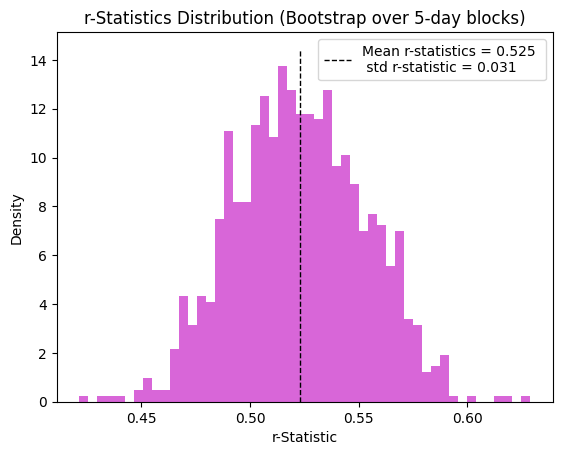

mean r-statistic: 0.5229812040876898
std r-statistic: 0.03013642588984928


In [9]:
#r statistics reale

from finrmt.spectra import r_stat

#bootstrap su r statistics, blocks of 5 days, on the real data matrix R



bootstrap_samples = 1000
r_stats_all = []
block_size = 5
num_blocks = T // block_size
for _ in range(bootstrap_samples):
    block_indices = np.random.choice(num_blocks, num_blocks, replace=True)
    sampled_indices = np.concatenate([np.arange(b*block_size, (b+1)*block_size) for b in block_indices])
    R_sampled = R[sampled_indices, :]
    C_sampled = (1/R_sampled.shape[0]) * R_sampled.T @ R_sampled
    eigs_sampled = np.linalg.eigvalsh(C_sampled)
    eigs_sorted = np.sort(eigs_sampled)
    r_stats = r_stat(eigs_sorted, trim_k=0)
    r_stats_all.append(r_stats)
plt.hist(r_stats_all, bins=50, density=True, alpha=0.6, color='m')
plt.vlines(np.mean(r_stats_all), color='k', linestyle='dashed', linewidth=1, label='Mean r-statistics = 0.525 \n std r-statistic = 0.031', ymin=0, ymax=plt.ylim()[1])
plt.legend()
plt.title("r-Statistics Distribution (Bootstrap over 5-day blocks)")
plt.xlabel("r-Statistic")
plt.ylabel("Density")
plt.show()

print("mean r-statistic:", np.mean(r_stats_all))
print("std r-statistic:", np.std(r_stats_all))
#bootstrap 
#p-value

In [13]:
from scipy import stats
mean_r = np.mean(r_stats_all)
s = np.std(r_stats_all, ddof=1)      # <-- importante
n = len(r_stats_all)
mu0 = 0.53

t_stat = (mean_r - mu0) / (s/np.sqrt(n))
p_value = 2 * stats.t.sf(abs(t_stat), df=n-1)  # due code
print(t_stat, p_value)

# oppure, direttamente:
t_stat2, p_value2 = stats.ttest_1samp(r_stats_all, mu0, alternative='two-sided')

-7.361284688933175 3.8005392552896925e-13


In [20]:
alpha = 0.02
tcrit = stats.t.ppf(1 - alpha/2, n-1)
ci = (mean_r - tcrit*s/np.sqrt(n), mean_r + tcrit*s/np.sqrt(n))
print("CI98%:", ci)

CI98%: (np.float64(0.520759526524007), np.float64(0.5252028816513725))


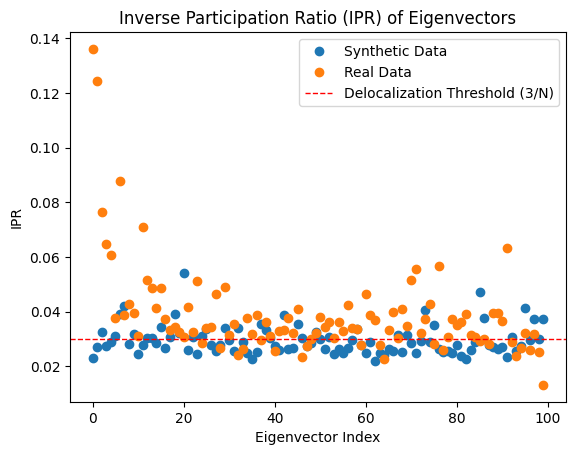

In [ ]:
#ipr on real data
from finrmt.spectra import ipr
eigvecs = np.linalg.eigh(C)[1]
ipr_values = ipr(eigvecs)
R_gauss = np.random.normal(0, 1, size=(T, N))
T, N = R.shape
C_gauss = (1/T) * R_gauss.T @ R_gauss
eigvecs_gauss = np.linalg.eigh(C_gauss)[1]
ipr_values_gauss = ipr(eigvecs_gauss)
#mark the outliers
plt.plot(ipr_values_gauss, 'o', label='Synthetic Data')
plt.plot(ipr_values, 'o', label='Real Data')
plt.axhline(3/N, color='r', linestyle='dashed', linewidth=1, label='Delocalization Threshold (3/N)', xmin=0, xmax=105)
plt.title("Inverse Participation Ratio (IPR) of Eigenvectors")
plt.xlabel("Eigenvector Index")
plt.ylabel("IPR")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# eigvals, eigvecs da np.linalg.eigh(C)
eigvals, eigvecs = np.linalg.eigh(C)

# calcolo IPR
ipr = np.sum(eigvecs**4, axis=0)

# soglia di delocalizzazione
thr = 3/C.shape[0]

outlier_idx = np.where(ipr > thr*2)[0]   # es. due volte la soglia
print("Autovettori localizzati:", outlier_idx)

for idx in outlier_idx:
    v = eigvecs[:, idx]
    top_assets = np.argsort(-np.abs(v))[:10]   # primi 10 titoli per modulo coefficiente
    print(f"Eigenvalue {eigvals[idx]:.2f}, IPR {ipr[idx]:.3f}")
    print("Top assets:", ret.columns[top_assets].to_list())


Autovettori localizzati: [ 0  1  2  3  4  6 11 91]
Eigenvalue 0.11, IPR 0.136
Top assets: ['CMS', 'BXP', 'AEE', 'CFG', 'BAC', 'ARE', 'C', 'AMP', 'AWK', 'ALLE']
Eigenvalue 0.11, IPR 0.124
Top assets: ['BXP', 'BAC', 'ARE', 'C', 'CFG', 'AMAT', 'ACGL', 'CNP', 'AMP', 'APH']
Eigenvalue 0.12, IPR 0.077
Top assets: ['AMT', 'CCI', 'AEP', 'AEE', 'BAC', 'CMS', 'AMAT', 'ANET', 'AWK', 'APH']
Eigenvalue 0.13, IPR 0.065
Top assets: ['CMS', 'CCI', 'AMT', 'AEP', 'BAC', 'ARE', 'AIG', 'C', 'ATO', 'CB']
Eigenvalue 0.13, IPR 0.061
Top assets: ['CCI', 'AMT', 'AMAT', 'ATO', 'AIG', 'AFL', 'CDNS', 'CMS', 'CFG', 'AME']
Eigenvalue 0.16, IPR 0.088
Top assets: ['AEE', 'AMP', 'AVB', 'ATO', 'ARE', 'ADI', 'ACGL', 'AEP', 'BAC', 'CB']
Eigenvalue 0.19, IPR 0.071
Top assets: ['AJG', 'AON', 'BRO', 'AVY', 'AMCR', 'BKR', 'APA', 'APH', 'BX', 'BLK']
Eigenvalue 1.59, IPR 0.063
Top assets: ['CHRW', 'APTV', 'AME', 'ACGL', 'APD', 'AFL', 'BA', 'CAT', 'BIIB', 'BALL']
